In [ ]:
from langchain_community.document_loaders import UnstructuredURLLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_mistralai import MistralAIEmbeddings
MISTRAL_API_KEY=""
embeddings = MistralAIEmbeddings(
    model="mistral-embed",mistral_api_key=MISTRAL_API_KEY
)
urls = ['https://www.victoriaonmove.com.au/local-removalists.html','https://victoriaonmove.com.au/index.html','https://victoriaonmove.com.au/contact.html']
loader=UnstructuredURLLoader(urls=urls)
docs_list=loader.load()

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [7]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_victoria_services",
    "Search and return information about Victoria company on moving services, apartment moving, and furniture moving.",
)

tools = [retriever_tool]

In [8]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
from langchain_mistralai.chat_models import ChatMistralAI
llm=ChatMistralAI(model_name='mistral-large-latest',mistral_api_key=MISTRAL_API_KEY)

In [10]:
llm.invoke("hi")

AIMessage(content="Hello! How can I assist you today? If you're up for it, I'd love to share a fun fact or a interesting topic to kick things off. How does that sound?", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 4, 'total_tokens': 44, 'completion_tokens': 40}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-2b86dc1e-c2ae-430d-a49d-300dd15b34fa-0', usage_metadata={'input_tokens': 4, 'output_tokens': 40, 'total_tokens': 44})

In [15]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

from langgraph.prebuilt import tools_condition


class grade(BaseModel):
    """Binary score for relevance check."""
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")


    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewriter"


In [12]:
def Assistent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL ASSISTENT---")
    messages = state["messages"]
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

In [13]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    response = llm.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


c:\Users\Wasib\miniconda3\envs\gen_ai\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [17]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

workflow.add_node("Assistent", Assistent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("Vector_Retriever", retrieve)  
workflow.add_node("Transform_Query", rewrite)  
workflow.add_node(
    "Output_Generator", generate
)  


workflow.add_edge(START, "Assistent")

workflow.add_conditional_edges(
    "Assistent",
    tools_condition,
    {
        "tools": "Vector_Retriever",
        END: END,
    },
)

workflow.add_conditional_edges(
    "Vector_Retriever",
    grade_documents,
    {"generator": "Output_Generator",
    "rewriter": "Transform_Query"
                            }
)
workflow.add_edge("Output_Generator", END)
workflow.add_edge("Transform_Query", "Assistent")

# Compile
graph = workflow.compile()

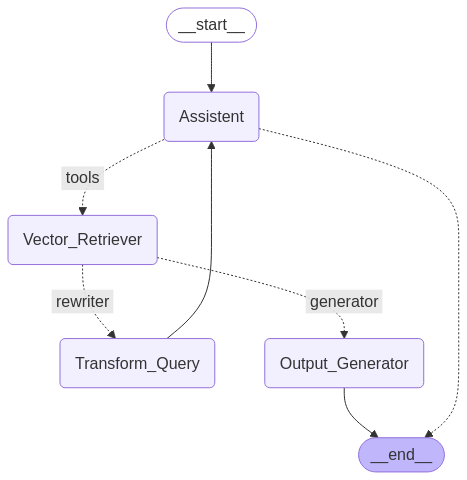

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
import pprint

inputs = {
    "messages": [
        ("user", "What services is Victoria offering?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL ASSISTENT---
"Output from node 'Assistent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fDbOoleh0', 'function': {'name': 'retrieve_victoria_services', 'arguments': '{"query": "Victoria company services"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 99, 'total_tokens': 129, 'completion_tokens': 30}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run-dfaea33f-0e61-4d2d-8d15-f58cf32739cb-0', tool_calls=[{'name': 'retrieve_victoria_services', 'args': {'query': 'Victoria company services'}, 'id': 'fDbOoleh0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 99, 'output_tokens': 30, 'total_tokens': 129})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'Vector_Retriever':"
'---'
{ 'messages': [ ToolMessage(content='Victoria on Move is your trusted local moving company in Melbourne, specializing in seamless relocation se

c:\Users\Wasib\miniconda3\envs\gen_ai\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'Output_Generator':"
'---'
{ 'messages': [ 'Victoria is offering local and interstate relocation '
                'services, including packing and moving for furniture. They '
                'specialize in providing seamless and stress-free moving '
                'experiences tailored to individual needs. Victoria is '
                'recognized for their commitment to quality and customer '
                'satisfaction in Melbourne.']}
'\n---\n'
